This code will analyze the FM-MS gate pulses, followed by two single qubit rotaion $R_{\theta}(\pi/2)$ on both ions. Measuring the $\sigma_{z1}\sigma_{z2}$ as the parity.

In [134]:
import msgate as ms

In [135]:
ms.__file__

'/Users/sunke/Desktop/DukeLab/+Code/ParityScan/msgate.py'

In [169]:
import qutip as qt
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import datetime
from numpy import linalg
#from numpy import *
import pandas as pd
from tqdm import tqdm
import msgate as ms
%matplotlib inline

class MSGateExp:
    def __init__(self, 
                spin=tensor(fock_dm(2,1),fock_dm(2,1)),
                posi = np.array([-1.,1.]),
                CarrierFreq = 222.646138921617e6,
                RedSB1_1 = 1.98472135e6,
                RedSB2_1 = 2.04612904e6,
                Stark4Photon = -0.010195552e3,
                RawFreq_sol = np.array([1.9504797294753649e6,
                                         1.977856646479975e6,
                                         1.9569086790102637e6,
                                         1.9745219633001168e6,
                                         1.966407554598451e6,
                                         1.975122077019819e6,
                                         1.9738779954630208e6,
                                         1.9748697407561622e6,
                                         1.9766151800769665e6,
                                         1.9758550554531902e6]),
                ion1 = 0,
                ion2 = 1,
                gate_time = 120e-6,
                rabi_freq = (77968.151)*0.1*2*np.pi,
                pwrBalance = np.ones([2,2]),
                motional_coherence = 3e-3,
                Gamma = [4, 10],
                laser_dp = 300e-3,
                Nmax = 10
                ):
        freq_sol = RawFreq_sol*2*np.pi
        
        mode_freq = np.array([RedSB1_1,RedSB2_1])*2*np.pi
        mode_freq.sort()
        self.spin = spin
        self.motional_coherence = motional_coherence
        self.Gamma = Gamma
        self.laser_dp = laser_dp
        self.Nmax = 20
        
        self.sim = ms.ModulatedMSGate()
        self.sim.set_attr_fm(ion1,
                        ion2,
                        gate_time,
                        freq_sol,
                        rabi_freq,
                        mode_freq,
                        posi,
                        pwrBalance = pwrBalance)
        
        
        
    def time_scan(self,Nsample,verbose = False):
        now = datetime.datetime.now()
        f,m1= self.sim.get_fidelity_fm(coherence_t = self.motional_coherence, 
                                       Gamma=self.Gamma, 
                                       verbose= verbose, 
                                       laser_dp =self.laser_dp,
                                       spin_init = self.spin, 
                                       Nsample=Nsample)
        fidelity = (f**2)
        #print(fidelity)
        now2 = datetime.datetime.now()
        #print(now2-now)
        return m1
        
    
    
    def detuning_scan(self,
                      delta_start,
                      delta_stop,
                      Nsample,
                      t1=np.linspace(0, 0.5, 2),
                      t2=np.linspace(0, 0.5, 2),
                     ):
        delta_list = np.linspace(delta_start, delta_stop, Nsample)
        states = []
        for delta in delta_list:
            self.delta_r = delta*np.array([1, 1])*np.pi*2
            self.delta_b = delta*np.array([-1, -1])*np.pi*2
            self.s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(self.Nmax, 0.5))
            self.solve(t1)
            states.append(self.output.states[-1])
        #states = np.array(states)
        self.measure(states, delta_list)
        
    def parity_scan(self,
                    phi_list = np.linspace(0,2*np.pi, 51),
                    omega1 = 0,
                    omega2 = 0,
                    t_rotation = 0,
                    deltaPhi = 0
                 ):
        output_states = self.time_scan(Nsample = 50)
        
        
        tlist = np.linspace(0, t_rotation, 21)
#         c_ops = [tensor(tensor(qeye(2), qeye(2)), np.sqrt(self.Gamma)*destroy(self.Nmax)),
#                  tensor(tensor(qeye(2), qeye(2)), np.sqrt(self.Gamma)*create(self.Nmax))]
        s_init = output_states
        parity = [] 
        for phi in phi_list:
            sigma_phi = np.cos(phi)*sigmax() - np.sin(phi)*sigmay()
            sigma_phi_2 = np.cos(phi+deltaPhi)*sigmax() - np.sin(phi+deltaPhi)*sigmay()
            H1 = omega1*tensor(sigma_phi, qeye(2))
            H2 = omega2*tensor(qeye(2), sigma_phi_2)
            H = H1+H2
            self.output = mesolve(H, s_init, tlist, [], [])
            szz = (self.output.states[-1]*tensor(sigmaz(),sigmaz())).tr() 
            parity.append(szz)
        plt.plot(phi_list, parity)
        plt.xlabel('Phase')
        plt.ylabel('Parity')
        plt.ylim([-1.001,1.001])
        contrast = (max(parity)-min(parity))/2
        print('contrast = ',contrast)
        return s_init
        
    def parity_scan_repeatable(self,
                    phi,
                    omega1 = 0,
                    omega2 = 0,
                    t_rotation = 0,
                    deltaPhi = 0
                 ):
        output_states = self.time_scan(Nsample = 50, verbose = False)
        
        
        tlist = np.linspace(0, t_rotation, 21)
        s_init = output_states
        
        sigma_phi = np.cos(phi)*sigmax() - np.sin(phi)*sigmay()
        sigma_phi_2 = np.cos(phi+deltaPhi)*sigmax() - np.sin(phi+deltaPhi)*sigmay()
        H1 = omega1*tensor(sigma_phi, qeye(2))
        H2 = omega2*tensor(qeye(2), sigma_phi_2)
        H = H1+H2
        self.output = mesolve(H, s_init, tlist, [], [])
        szz = (self.output.states[-1]*tensor(sigmaz(),sigmaz())).tr() 
        return szz, s_init
        
        
    def measure(self, states, x_axis, isPlot = True):
        # states: np.array of dm includes two ions and phonons
        s_ee = tensor(fock(2, 0), fock(2, 0))
        s_gg = tensor(fock(2, 1), fock(2, 1))
        s_eg = (tensor(fock(2, 0), fock(2, 1)) +
                tensor(fock(2, 1), fock(2, 0))).unit()
        
        def _measure(state, s_meas):
            state_ptr = state.ptrace([0,1])  
            result = s_meas.dag()*state_ptr*s_meas
            if result.data.data.size:
                return np.real(result.data.data[0])
            else:
                return 0.0    # np.array has same type
         
        ee = np.zeros(len(states))
        gg = np.zeros(len(states))
        eg = np.zeros(len(states))
        for i in range(len(states)):
            ee[i] = _measure(states[i], s_ee)
            gg[i] = _measure(states[i], s_gg)
            eg[i] = _measure(states[i], s_eg)
        if isPlot:
            fig, ax = plt.subplots()
            ax.plot(x_axis, ee)
            ax.plot(x_axis, gg)
            ax.plot(x_axis, eg)
            # ax.set_xlabel()
            ax.set_ylabel('Probability')
            ax.legend(('11', '00', '01+10'))
            plt.show()
       

In [153]:
exp1 = MSGateExp(pwrBalance = np.array([[1., 1.05],
       [1., 1.05]]))
states = exp1.time_scan(Nsample = 50)
states

....................
....................


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.53288134-7.90031463e-18j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.0052067 -4.90589180e-01j]
 [ 0.        +0.00000000e+00j  0.00557616-6.46911254e-18j
  -0.0052067 -2.69780702e-04j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j -0.0052067 +2.69780702e-04j
   0.00553102+6.68437535e-18j  0.        +0.00000000e+00j]
 [ 0.0052067 +4.90589180e-01j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.45601148+8.07914149e-18j]]

## Idea case:

contrast =  0.9966024630397818


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 4.99593623e-01+1.20027067e-17j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  2.18391554e-04-4.99286589e-01j]
 [ 0.00000000e+00+0.00000000e+00j  3.10839961e-04+2.54455719e-18j
  -2.18391554e-04+1.05657864e-17j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -2.18391554e-04-1.11415843e-17j
   3.10839961e-04-2.75100356e-18j  0.00000000e+00+0.00000000e+00j]
 [ 2.18391554e-04+4.99286589e-01j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  4.99784697e-01-1.17940453e-17j]]

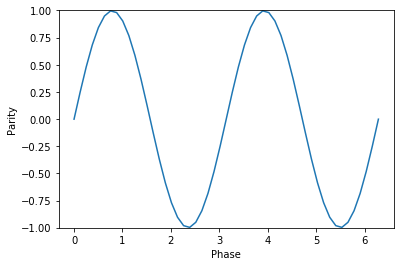

In [170]:
f = open("2_ion_fm1647463153.239342.yml", "r")
paras = f.read().splitlines()
RedSB1_1 = float(paras[0])
RedSB2_1 = float(paras[1])
gate_time = float(paras[2])
freq_sol = [float(paras[i])*1e6 for i in range(3,3+10)]
CarrierFreq = float(paras[-2])*1e6
CarrierRabi = float(paras[-1])

exp = MSGateExp(spin=tensor(fock_dm(2,1),fock_dm(2,1)),
                posi = np.array([-1.,1.]),
                CarrierFreq = CarrierFreq,
                RedSB1_1 = RedSB1_1,
                RedSB2_1 = RedSB2_1,
                Stark4Photon = 0,
                RawFreq_sol = np.array(freq_sol),
                ion1 = 0,
                ion2 = 1,
                gate_time = gate_time,
                rabi_freq = (CarrierRabi)*0.1*2*np.pi,
                motional_coherence = 100e-3,
                Gamma = [4, 10],
                laser_dp = 300e-3,
                Nmax = 10)
t_Raman = 4e-6 # pi time
omega = np.pi/2/t_Raman
omega1 = omega
omega2 = omega
s_ms = exp.parity_scan(phi_list = np.linspace(0,2*np.pi, 51),
                    omega1 = omega1,
                    omega2 = omega2,
                    t_rotation = t_Raman/2 # pi/2 rotation
                         )
s_ms

# Consider the shot-to-shot intensity noise
Ideal case, the relative phases between $\Delta\phi_r$ and $\Delta\phi_b$ are kepted to be the same.








  0%|          | 0/31 [00:00<?, ?it/s]






  3%|▎         | 1/31 [02:00<1:00:12, 120.43s/it]






  6%|▋         | 2/31 [04:02<58:30, 121.06s/it]  






 10%|▉         | 3/31 [06:08<57:03, 122.28s/it]






 13%|█▎        | 4/31 [08:15<55:43, 123.85s/it]






 16%|█▌        | 5/31 [10:21<53:54, 124.41s/it]






 19%|█▉        | 6/31 [12:27<52:04, 124.98s/it]






 23%|██▎       | 7/31 [14:31<49:54, 124.77s/it]






 26%|██▌       | 8/31 [16:35<47:39, 124.33s/it]






 29%|██▉       | 9/31 [18:39<45:35, 124.36s/it]






 32%|███▏      | 10/31 [20:47<43:54, 125.47s/it]






 35%|███▌      | 11/31 [22:55<42:03, 126.16s/it]






 39%|███▊      | 12/31 [25:04<40:14, 127.05s/it]






 42%|████▏     | 13/31 [27:13<38:16, 127.59s/it]






 45%|████▌     | 14/31 [29:21<36:12, 127.82s/it]






 48%|████▊     | 15/31 [31:33<34:23, 128.97s/it]






 52%|█████▏    | 16/31 [33:50<32:51, 131.44s/it]






 55%|█████▍    | 17/31 [36:01<30:37, 131.27s/it]






 58%|█████▊    | 1

(-1.001, 1.001)

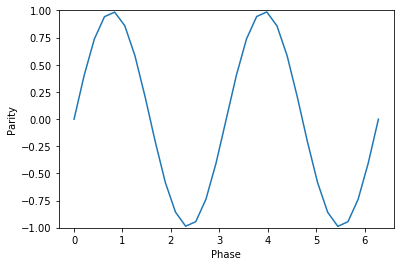

In [162]:
f = open("2_ion_fm1647463153.239342.yml", "r")
paras = f.read().splitlines()
RedSB1_1 = float(paras[0])
RedSB2_1 = float(paras[1])
gate_time = float(paras[2])
freq_sol = [float(paras[i])*1e6 for i in range(3,3+10)]
CarrierFreq = float(paras[-2])*1e6
CarrierRabi = float(paras[-1])

t_Raman = 4e-6 # pi time
omega = np.pi/2/t_Raman
omega1 = omega
omega2 = omega

phi_list = np.linspace(0,2*np.pi, 31)
szzs = []
expr_num = 50

for phi in tqdm(phi_list):
    exp_result = 0.0
    mu, sigma = 1, 0.05
    pwr_ub = np.random.normal(mu, sigma, expr_num)
    for i in range(expr_num):  
        exp = MSGateExp(spin=tensor(fock_dm(2,1),fock_dm(2,1)),
                posi = np.array([-1.,1.]),
                CarrierFreq = CarrierFreq,
                RedSB1_1 = RedSB1_1,
                RedSB2_1 = RedSB2_1,
                Stark4Photon = 0,
                RawFreq_sol = np.array(freq_sol),
                ion1 = 0,
                ion2 = 1,
                gate_time = gate_time,
                rabi_freq = (CarrierRabi)*0.1*2*np.pi,
                pwrBalance = np.array([[1., pwr_ub[i]],
                                       [1., pwr_ub[i]]]),
                motional_coherence = 100e-3,
                Gamma = [4, 10],
                laser_dp = 300e-3,
                Nmax = 10)

        szz, s_init=exp.parity_scan_repeatable(
                    phi = phi,
                    omega1 = omega1,
                    omega2 = omega1*pwr_ub[i],
                    t_rotation = t_Raman/2, # pi/2 rotation
                    deltaPhi = 0
                 )
        exp_result+=szz
    szzs.append(exp_result/expr_num)
    
plt.plot(phi_list, szzs)
plt.xlabel('Phase')
plt.ylabel('Parity')
plt.ylim([-1.001,1.001])

In [166]:
contrast = (max(szzs)-min(szzs))/2
contrast

0.9870384985714792

Gaussian noise:
    
$\mu = 0, \quad \sigma = 0.1\times2\pi$ 

phi_b_list = `np.random.normal`($\mu, \sigma$, expr_num)

phi_r_list = `np.random.normal`($\mu, \sigma$, expr_num)

White noise: 

    phi_b_list = [rd.random()*2*np.pi for i in range(expr_num)]

    phi_r_list = [rd.random()*2*np.pi for i in range(expr_num)]

### Check the raman rotation parameters

In [62]:
t_Raman = 6e-6
omega = np.pi/2/t_Raman
omega1 = omega
omega2 = omega
Nmax = 10
phi= 0.0

sigma_phi = np.cos(phi)*sigmax() - np.sin(phi)*sigmay()
H1 = omega1*tensor(sigma_phi, qeye(2), qeye(Nmax))
H2 = omega2*tensor(qeye(2), sigma_phi, qeye(Nmax))
H = H1+H2
tlist = np.linspace(0, t_Raman/2, 101)
s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, 0.1))
output = mesolve(H, s_init, tlist, [], [])

szs = [(state.ptrace([0,1])*tensor(sigmaz(),qeye(2))).tr() for state in output.states]
szzs = [(state.ptrace([0,1])*tensor(sigmaz(),sigmaz())).tr() for state in output.states]

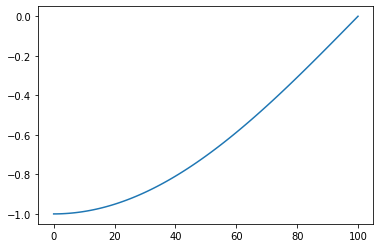

In [63]:
plt.plot(szs)

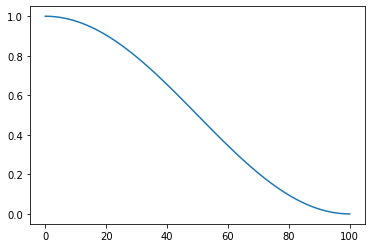

In [64]:
plt.plot(szzs)

In [216]:
tensor(sigmay(),sigmax()) - tensor(sigmax(), sigmay())

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-2.j 0.+0.j]
 [0.+0.j 0.+2.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]